In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom
from lsst.afw import image as afwImage

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

In [109]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)


In [7]:
# at the moment comcam only in Cassandra
# from lsst.analysis.ap import apdbCassandra
# or4_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcamsim_or4.py')
# comcam_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcam.py')

In [8]:
# Load collection
repo = "embargo_new"
collection = "LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841"
instrument = "LSSTComCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [9]:
bands = ["u", "g", "r", "i", "z", "y"]

verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_differenceExp", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 247 differenceExps for band 'u'
Found 774 differenceExps for band 'g'
Found 2662 differenceExps for band 'r'
Found 1777 differenceExps for band 'i'
Found 765 differenceExps for band 'z'
Found 584 differenceExps for band 'y'


In [12]:
i = 50
data_id = datasetRefs_dia[i].dataId
print(data_id)

{instrument: 'LSSTComCam', detector: 0, visit: 2024112000314, band: 'y', day_obs: 20241120, physical_filter: 'y_04'}


In [39]:
# coord = lsst.geom.SpherePoint(targetCoord.ra.deg, targetCoord.dec.deg, units=lsst.geom.degrees)
# tract_info = skymap.findTract(coord)

In [61]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")
print(len(lc_refs))
print(len(obj_refs))

43
43


Text(0, 0.5, 'Number of diaObjects')

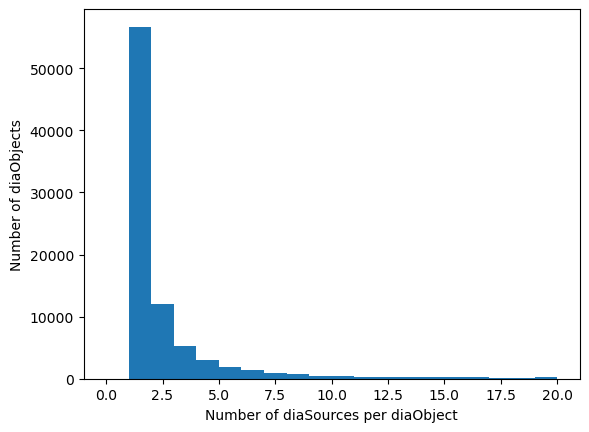

In [69]:
# select one tract
obj_ref = obj_refs[31]
dia_Obj = butler.get(obj_ref)

# select the diaSource for the same tract
diaSource = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)

plt.hist(dia_Obj['nDiaSources'], bins=20, range=(0, 20));
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Number of diaObjects')

In [72]:
dia_Obj['nDiaSources'].describe()

count    86162.000000
mean         2.459205
std          3.961566
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         39.000000
Name: nDiaSources, dtype: float64

In [75]:
dia_Obj_many_Src = dia_Obj[dia_Obj['nDiaSources']>35]

In [86]:
dia_Obj_many_Src.index[0]

2430439666873270276

In [88]:
lc = diaSource[diaSource['diaObjectId'] == dia_Obj_many_Src.index[0]]
lc;

In [ ]:
"""
dia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)
template = butler.get("goodSeeingDiff_templateExp", dataId=data_id)
calexp = butler.get("calexp", dataId=data_id)
src = butler.get("src", dataId=data_id)
dia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)
dia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) 
"""

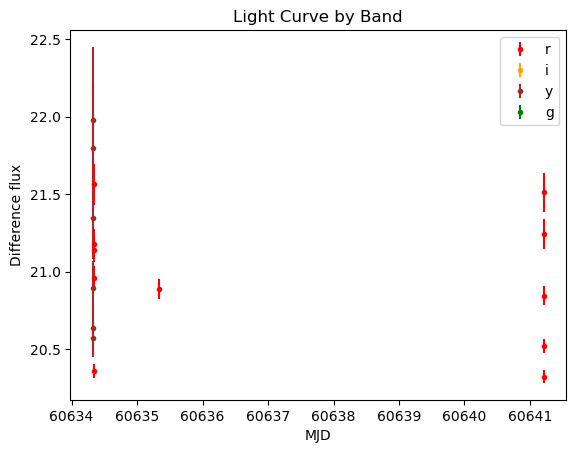

In [93]:
import matplotlib.pyplot as plt

# Define LSST band colors
band_colors = {
    "u": "purple",
    "g": "green",
    "r": "red",
    "i": "orange",
    "z": "darkgray",
    "y": "brown"
}

# Create the figure
fig = plt.figure()

# Plot the data for each band
for band in set(lc['band']):
    lcb = lc.query(f'band == "{band}"')
    # Convert flux and flux error to magnitudes
    mag, magErr = create_mag_errors(lcb['psfFlux'], lcb['psfFluxErr'])
    
    # Plot magnitudes with errors
    plt.errorbar(
        lcb['midpointMjdTai'], 
        mag, 
        magErr, 
        label=band, 
        linestyle='none', 
        fmt='.', 
        color=band_colors.get(band, 'black')  # Use black as default for unknown bands
    )

# Add legend, labels, and display
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Difference flux')
plt.title('Light Curve by Band')
plt.show()

In [99]:
mag, magErr = create_mag_errors(diaSource['scienceFlux'], diaSource['scienceFluxErr'])

In [115]:
print(diaSource['band'].unique())

['g' 'i' 'r' 'y']


In [118]:
# Step 1: Calculate mean flux for each diaObjectId in each band
mean_flux_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['scienceFlux'].mean().unstack(fill_value=0)

# Rename columns dynamically for all bands
band_flux_columns = {band: f"{band}_band_flux_mean" for band in ['g', 'r', 'i', 'y']}
mean_flux_per_object_band = mean_flux_per_object_band.rename(columns=band_flux_columns).reset_index()

# Step 2: Merge mean flux values into dia_Obj_field
dia_Obj_field_updated = dia_Obj.merge(mean_flux_per_object_band, on='diaObjectId', how='left')

# Step 3: Calculate magnitudes for all bands
for band in [ 'g', 'r', 'i',  'y']:
    flux_col = f"{band}_band_flux_mean"
    mag_col = f"{band}_band_mag"
    dia_Obj_field_updated[mag_col] = dia_Obj_field_updated[flux_col].apply(create_mag)

# Replace infinite values with NaN
dia_Obj_field_updated.replace([np.inf, -np.inf], np.nan, inplace=True)

# Select and display the magnitude columns
output_columns = [f"{band}_band_mag" for band in ['g', 'r', 'i', 'y']]
result = dia_Obj_field_updated[output_columns]

     

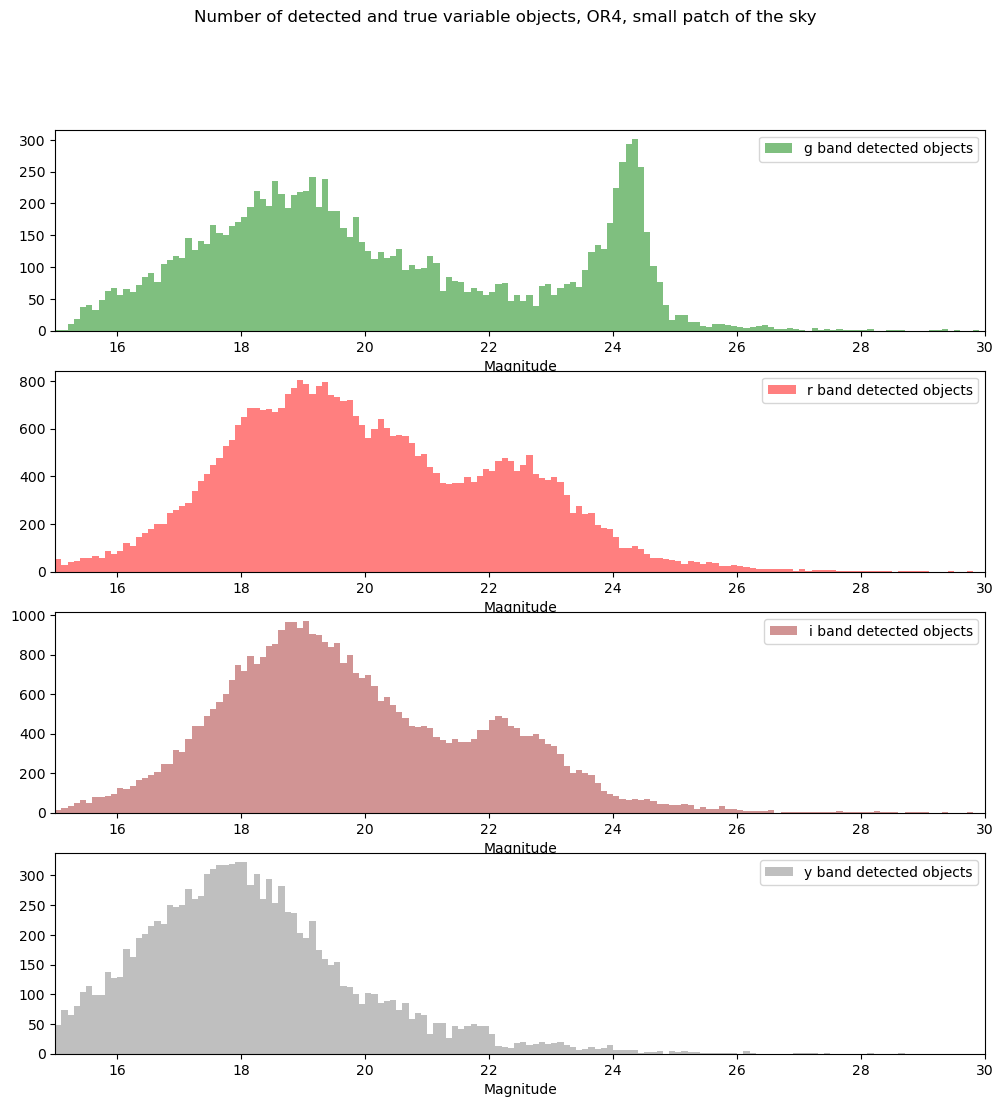

In [ ]:
plt.figure(figsize=(12, 12))
plt.suptitle('Number of detected objects, OR4, small patch of the sky')

plt.subplot(4, 1, 1)
plt.hist(result['g_band_mag'][~np.isnan(result['g_band_mag'])], color='g', alpha=0.5, bins=np.arange(15,30,0.1), label='g band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(4, 1, 2)
plt.hist(result['r_band_mag'][~np.isnan(result['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(4, 1,3)
plt.hist(result['i_band_mag'][~np.isnan(result['i_band_mag'])], color='brown', alpha=0.5, bins=np.arange(15,30,0.1), label='i band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(4, 1,4)
plt.hist(result['y_band_mag'][~np.isnan(result['y_band_mag'])], color='gray', alpha=0.5, bins=np.arange(15,30,0.1), label='y band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

In [ ]:
plt.hist(dia_Obj_field_updated['r_band_mag'][~np.isnan(dia_Obj_field_updated['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');


,ra,dec,nDiaSources,radecMjdTai,g_psfFluxLinearSlope,g_psfFluxLinearIntercept,g_psfFluxMAD,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,...,y_psfFluxPercentile05,y_psfFluxPercentile25,y_psfFluxPercentile50,y_psfFluxPercentile75,y_psfFluxPercentile95,y_psfFluxSigma,y_scienceFluxSigma,y_psfFluxSkew,y_psfFluxChi2,y_psfFluxStetsonJ
diaObjectId,,,,,,,,,,,,,,,,,,,,,
2430382492268625921,95.505391,-25.224280,1,60634.328488,NaN,NaN,NaN,NaN,NaN,NaN,...,-15637.508183,-15637.508183,-15637.508183,-15637.508183,-15637.508183,NaN,NaN,NaN,0.000000e+00,NaN
2430382492268625922,95.516505,-25.217411,2,60641.219499,NaN,NaN,NaN,NaN,NaN,NaN,...,-21057.774073,-21057.774073,-21057.774073,-21057.774073,-21057.774073,NaN,NaN,NaN,0.000000e+00,NaN
2430382492268625923,95.512656,-25.221502,1,60634.328488,NaN,NaN,NaN,NaN,NaN,NaN,...,-28674.863781,-28674.863781,-28674.863781,-28674.863781,-28674.863781,NaN,NaN,NaN,1.335812e-30,NaN
2430382492268625924,95.497516,-25.216558,5,60641.214104,-507086.423033,3.075034e+10,446.834704,-249531.510751,349.311672,2417.469318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430382492268625925,95.497339,-25.222527,1,60634.332367,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430619986780226346,94.763380,-24.532024,1,60641.220116,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430619986780226347,94.763274,-24.533838,1,60641.220116,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430619986780226348,94.921134,-24.527149,1,60641.221447,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


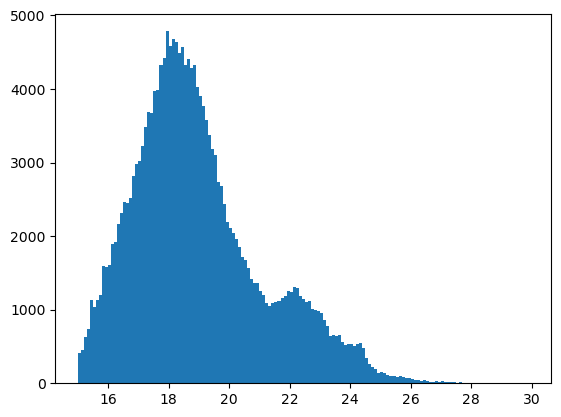

In [102]:
plt.hist(mag, bins=np.arange(15,30,0.1));

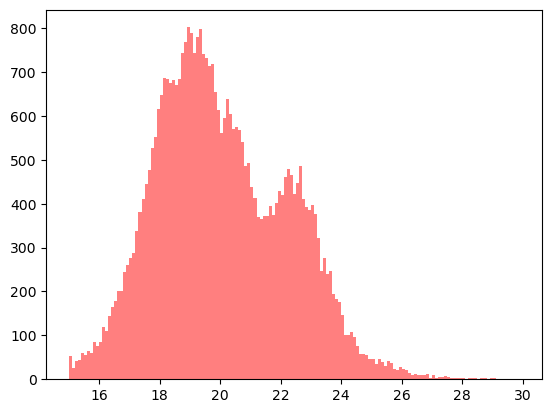

In [111]:
plt.hist(dia_Obj_field_updated['r_band_mag'][~np.isnan(dia_Obj_field_updated['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');


In [31]:
registry = butler.registry
query="instrument='LSSTComCam'"
results = registry.queryDimensionRecords('exposure', where=query)

In [33]:
results.count()

12316

In [15]:
visit = butler.registry.dimensions["visit"]

In [22]:
!butler query-dimension-records embargo exposure --where  "instrument='LSSTComCam' and exposure in (2024112000314)"  

instrument       id      day_obs           group          physical_filter        obs_id        exposure_time dark_time observation_type observation_reason seq_num seq_start seq_end   target_name    science_program    tracking_ra        tracking_dec        sky_angle          azimuth         zenith_angle    has_simulated can_see_sky               timespan (TAI)              
---------- ------------- -------- ----------------------- --------------- -------------------- ------------- --------- ---------------- ------------------ ------- --------- ------- ---------------- --------------- ----------------- ------------------- ----------------- ----------------- ------------------ ------------- ----------- ------------------------------------------
LSSTComCam 2024112000314 20241120 2024-11-21T08:15:45.714            y_04 CC_O_20241120_000314          30.0   30.4353          science            science     314       314     314 Rubin_SV_095_-25       BLOCK-320 94.89669413064276 -25.068895190687

In [ ]:
butler.get

In [16]:
print(visit.RecordClass.fields)


visit: 
  instrument: str
  id: int
  day_obs: int
  physical_filter: str
  name: str
  seq_num: int
  exposure_time: float
  target_name: str
  observation_reason: str
  science_program: str
  azimuth: float
  zenith_angle: float
  region: lsst.sphgeom.Region
  timespan: lsst.daf.butler.Timespan


In [19]:
expanded = butler.registry.expandDataId({"instrument": instrument, "visit": 2024112000314})
print(dict(expanded.full))

AttributeError: full